In [24]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.neighbors import LocalOutlierFactor


Carichiamo il dataset utilizzato nelle sessioni precedenti

In [25]:
train_data = pd.read_csv('../data/adult_training.csv')
y_train = train_data['income']
x_train = train_data.drop(['income'], axis =1)

test_data = pd.read_csv('../data/adult_test.csv')
y_test = test_data['income']
x_test = test_data.drop(['income'], axis =1)

Creiamo pre-processor e alleniamo modello

In [26]:

ordinal_features = x_train.select_dtypes(include="number").columns
categorical_features = x_train.select_dtypes(include="object").columns

ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

x_encoder = ColumnTransformer(transformers=[('ord', ordinal_transformer, ordinal_features),
                                                ('cat', categorical_transformer, categorical_features)])


x_encoder.fit(x_train)

clf = RandomForestClassifier(n_estimators=50,max_depth=6,criterion="entropy",min_samples_leaf=5)#.fit(x_encoder.transform(x_train),y_train)


rf_pipeline = Pipeline(steps=[("preprocessing", x_encoder), ("rf_model", clf)])
rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['work_class', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='o

# Analisi calibrazione modello

Utilizziamo la funzione *calibration_curve* da scikitlearn per valutare se siamo in presenza di un modello calibrato

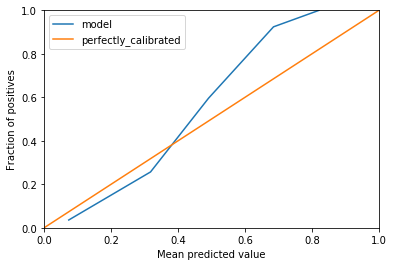

In [35]:
p_true, p_pred = calibration_curve(y_test, clf.predict_proba(x_encoder.transform(x_test))[:, 1])

plt.plot(p_pred, p_true, label='model')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='perfectly_calibrated')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()

In [33]:
x_test.shape

(10090, 12)

Il grafico mostra come il modello non sia calibrato. In questo caso siamo in presenza di un modello troppo timido, tra 0.5<P<0.9 il rateo di successo del modello sul test set e' stato piu' alto della confidenza in output.

Possiamo calibrare il modello usando la classe CalibratedClassifierCV che, prendendo in input il modello originale, allena un classificatore calibrando (usando la tecnica isotonic regression)


In [31]:
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=3, method='isotonic')
calibrated_clf.fit(x_encoder.transform(x_train), y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                             max_depth=6,
                                                             min_samples_leaf=5,
                                                             n_estimators=50),
                       cv=3, method='isotonic')

Andiamo a vedere come vada la calibrazione per il classificatore calibrated_clf

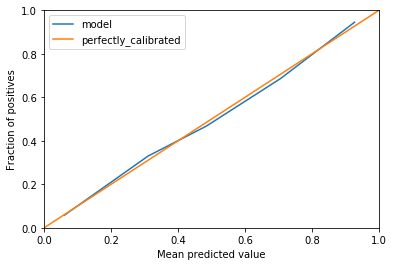

In [32]:
p_true, p_pred = calibration_curve(y_test, calibrated_clf.predict_proba(x_encoder.transform(x_test))[:, 1])

plt.plot(p_pred, p_true, label='model')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='perfectly_calibrated')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()

Molto meglio!

# Anomaly detection
Utilizziamo 2 librerie incluse in scikit-learn per effettuare analisi delle anomalie.

Cominciamo con la tecnica dell'*isolation forest*. Il parametro *contamination* e' il piu' importante quando si utilizza questo tipo di tecnica in quanto richiede di specificare a priori la definizione di outlier

In [77]:
isolation_for = IsolationForest(random_state=0, contamination = 0.01, n_estimators=60).fit(x_encoder.transform(x_train))

Troviamo quali punti siano stati identificati come anomalia sul test set


In [80]:
anomalies = isolation_for.predict(x_encoder.transform(x_test))

In [81]:
i1 = np.where(anomalies==-1)
print('Fraction of outliers:',i1[0].shape[0]/x_test.shape[0])

Fraction of outliers: 0.011000991080277503


In [64]:
x_test.iloc[i1[0]]

,age,work_class,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,Local-gov,Masters,Married,Professional,Wife,White,Female,0.0,0.0,28.0,United-States
1,65,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0.0,0.0,50.0,United-States
2,56,Private,Dropout,Married,Blue-Collar,Husband,White,Male,0.0,0.0,40.0,Portugal
3,21,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0.0,0.0,40.0,United-States
4,31,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0.0,0.0,40.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
995,71,Private,Dropout,Married,Blue-Collar,Husband,White,Male,0.0,0.0,40.0,United-States
996,44,Private,High School grad,Never-Married,Admin,Not-in-family,White,Female,0.0,0.0,43.0,United-States
997,41,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0.0,0.0,40.0,United-States
998,51,Private,Dropout,Never-Married,Service,Other-relative,Asian-Pac-Islander,Male,0.0,0.0,35.0,United-States


Utilizziamo adesso la tecnica 'Local Outlier Factor'. Anche in questo caso usiamo il parametro *contamination* per definire una soglia di anomalia.

In [90]:
lof= LocalOutlierFactor(n_neighbors=1, novelty=True, n_jobs=-1, contamination = 0.01, metric='hamming').fit(x_encoder.transform(x_train).toarray())

In [92]:
anomalies_lof = lof.predict(x_encoder.transform(x_test).toarray())

In [93]:
i1 = np.where(anomalies_lof==-1)
print('Fraction of outliers:',i1[0].shape[0]/x_test.shape[0])

Fraction of outliers: 0.0076313181367690785


In [94]:
x_test.iloc[i1[0]]

,age,work_class,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
36,80,Private,High School grad,Widowed,Service,Not-in-family,Black,Male,0.0,0.0,15.0,United-States
40,53,Self-emp-inc,High School grad,Married,Sales,Husband,White,Male,0.0,1887.0,48.0,British-Commonwealth
139,22,Private,High School grad,Never-Married,Service,Not-in-family,Asian-Pac-Islander,Male,1055.0,0.0,20.0,China
174,35,Federal-gov,High School grad,Married,Service,Wife,White,Female,7298.0,0.0,40.0,United-States
287,55,Private,High School grad,Married,Blue-Collar,Husband,White,Male,4508.0,0.0,8.0,Yugoslavia
...,...,...,...,...,...,...,...,...,...,...,...,...
9059,25,Private,High School grad,Never-Married,Blue-Collar,Not-in-family,White,Male,0.0,0.0,36.0,Other
9094,21,Private,High School grad,Never-Married,Admin,Own-child,White,Male,0.0,0.0,43.0,Germany
9316,42,Self-emp-not-inc,Associates,Separated,Blue-Collar,Not-in-family,White,Male,0.0,0.0,40.0,SE-Asia
9517,33,State-gov,High School grad,Never-Married,Blue-Collar,Other-relative,White,Male,0.0,0.0,40.0,United-States
